# 實作DCGAN演算法，產生名人臉部
### 程式修改自[DCGAN to generate face images](https://keras.io/examples/generative/dcgan_overriding_train_step/)

In [ ]:
# 載入相關套件
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

## 取得訓練資料

In [ ]:
# data_url = 'https://docs.google.com/uc?export=download&id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684'
# ! gdown 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
# !unzip -qq ./img_align_celeba.zip -d ./celeba_gan

Downloading...
From (original): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
From (redirected): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684&confirm=t&uuid=b73cb329-8f5a-49c4-9ca1-f31495b458b9
To: /content/img_align_celeba.zip
100% 1.44G/1.44G [00:29<00:00, 48.2MB/s]


In [ ]:
zip_dir = './celeba_gan'
dataset = keras.preprocessing.image_dataset_from_directory(
    zip_dir, label_mode=None, image_size=(64, 64), batch_size=32
)
os.makedirs(zip_dir)

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "./data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("./data.zip", "r") as zipobj:
    zipobj.extractall("./celeba_gan")

In [ ]:
# 從celeba_gan目錄產生資料集
zip_dir = './celeba_gan'
dataset = keras.preprocessing.image_dataset_from_directory(
    zip_dir, label_mode=None, image_size=(64, 64), batch_size=32
)
# 像素標準化
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files.


## 載入並顯示圖檔

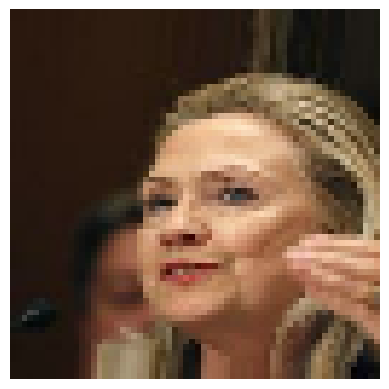

In [ ]:
# 載入並顯示第一個圖檔
image = next(iter(dataset))
plt.axis("off")
plt.imshow((image.numpy() * 255).astype("int32")[0])

## 定義判别神經網路

In [ ]:
# 判别神經網路
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

## 定義生成神經網路

In [ ]:
# 生成神經網路
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 8192)                │       1,056,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 3)           │          38,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

## 定義GAN，組合兩個網路。

In [ ]:
# 定義GAN，組合兩個網路
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    # 編譯：定義損失函數
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # 效能指標：判别神經網路、生成神經網路
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # 訓練
    def train_step(self, real_images):
        # 隨機抽樣 batch_size 筆，維度大小：latent_dim(128)
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 生成圖像
        generated_images = self.generator(random_latent_vectors)

        # 與訓練資料結合
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # 訓練資料的標籤設為 1，生成圖像的標籤設為 0
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # 將標籤加入雜訊，此步驟非常重要
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # 訓練判别神經網路
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # 隨機抽樣 batch_size 筆，維度大小：latent_dim(128)
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 生成圖像的標籤設為 0
        misleading_labels = tf.zeros((batch_size, 1))

        # 訓練生成神經網路，注意，不可更新判别神經網路的權重，只更新生成神經網路的權重
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # 計算效能指標
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## 建立自訂的 Callback，在訓練過程中儲存圖像

In [ ]:
# 建立自訂的 Callback，在訓練過程中儲存圖像
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    # 在每一執行週期結束時產生圖像
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            # 儲存圖像
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("./GAN_generated/img_%03d_%d.png" % (epoch, i))

## 訓練模型

In [ ]:
if not os.path.exists("./GAN_generated"):
    os.makedirs("./GAN_generated")

In [ ]:
# 訓練模型
epochs = 1  # 訓練週期正常需要100次

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# 產生10張圖像
gan.fit(
    dataset, epochs=epochs, # callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

  13/6332 ━━━━━━━━━━━━━━━━━━━━ 49:12:09 28s/step - d_loss: 0.6646 - g_loss: 0.8138

KeyboardInterrupt: 

In [ ]:
from IPython.display import Image

Image("./GAN_generated/img_000_0.png")

In [ ]:
import matplotlib.pyplot as plt


for i, x in enumerate(os.listdir("./GAN_generated")):
    plt.subplot(2,5,i+1)
    img = plt.imread("./GAN_generated/" + x)
    plt.imshow(img)